In [3]:
cd ..

/Users/jwen/Stanford/projects/smoke_segmentation


In [4]:
cd src

/Users/jwen/Stanford/projects/smoke_segmentation/src


In [109]:
import pandas as pd
import numpy as np
import glob
import geopandas as gpd
import matplotlib as mpl
import math
import time 
import json

# import solaris as sol

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from skimage import io
from utils import helpers as h
from utils import data_downloader as dd
from utils import data_vis as dv
from utils import data_prep as dp
from matplotlib import pyplot as plt
# from train_pipeline import fai_data_utils as fdu
# import fastai.vision as faiv
# import fastai.core as faic
import torch

%matplotlib inline

In [110]:
%load_ext autoreload
%autoreload 2

In [5]:
# read in the plume data
cali_fire_season_plumes = gpd.read_file('../data/ca_nv_fire_season_plumes.geojson')

## Generate Index File
* before mask generation in case we need to modify the polygons...
* there are ~2000 images for CA, but only some of them have smoke, hence the generating mask function will reduce the number of images further

In [442]:
def create_file_index(smoke_df):
    # create dictionary for storing filenames
    index_dict = {'true_color':[], 'C07':[], 'C11':[]}
    e_dict = {}
    
    # iterate through the smoke plume dataset and create a mask for each observation
    for row in smoke_df.itertuples():
        tc_slug = h.get_true_color_filename_slug(row)
        
        # catch situations where no matching image file found (due to download errors from AWS)
        try:
            tc_file_name = glob.glob('../data/img/{}*.tiff'.format(tc_slug))[0].split('/')[-1]
            
        except IndexError as e:
            e_str = str(e)
            if e_str not in e_dict:
                e_dict[e_str] = 1
            else:
                e_dict[e_str] += 1
                
            continue
        
        # create filenames to be stored in the index file
        temp_file_name = '_'.join(tc_file_name.split('_')[2:])
        
        index_dict['true_color'] += [tc_file_name]
        index_dict['C07'] += ['C07_' + temp_file_name]
        index_dict['C11'] += ['C11_' + temp_file_name]
        
    print(e_dict)
    
    index_df = pd.DataFrame.from_dict(index_dict)
    
    ## remove duplicates (because multiple smoke polygons could have been on the same image)
    index_df.drop_duplicates(inplace=True)
    index_df = index_df.sort_values(by='true_color')
    
    ## create image id for downstream polygon editing (add 1 cause COCO starts at 1)
    index_df['image_id'] = index_df.reset_index().index + 1
    
    index_df.to_csv('../data/filename_index.csv', index=False)

In [443]:
create_file_index(cali_fire_season_plumes)

{'list index out of range': 292}


## Generate Polygon JSON
* create json in the COCO format for segmentation mask adjustment using CVAT

In [6]:
# read in the index file with image file names
index_df = pd.read_csv('../data/filename_index.csv')

In [7]:
# generate new smoke dataframe and COCO json
dp.generate_coco_json_smoke_df(index_df.head(), 
                            smoke_plume_df = cali_fire_season_plumes, 
                            save_smoke_data_fn = 'test_coco_smoke_df', 
                            save_json_data_fn = 'test_coco_json')

 ## Generate Masks

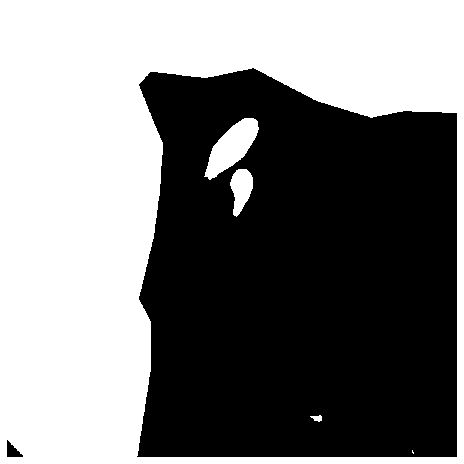

In [350]:
# interate over file and create mask for each image
index_df['mask'] = index_df['true_color'].head().apply(dv.generate_smoke_mask_wrapper, 
                                                       smoke_plume_df=cali_fire_season_plumes)

# save new index file
index_df.to_csv('../data/filename_index.csv', index=False)

In [ ]:
## view images
mask_G16_doy202_s201807212345_e201807212356
mask_G16_doy292_s201810192145_e201810192156.tiff
mask_G16_doy292_s201810192230_e201810192241
mask_G16_doy292_s201810192345_e201810192356.tiff

## Tiling images

In [30]:
idx_df = pd.read_csv('../data/filename_index.csv')

In [31]:
unique_idx_df = idx_df.drop_duplicates(['true_color', 'C07', 'C11']).reset_index(drop=True)

In [32]:
unique_idx_df.head()

,true_color,C07,C11,mask
0,true_color_G16_doy225_s201808132130_e201808132...,C07_G16_doy225_s201808132130_e201808132141.tiff,C11_G16_doy225_s201808132130_e201808132141.tiff,mask_G16_doy225_s201808132130_e201808132141.tiff
1,true_color_G16_doy232_s201808202230_e201808202...,C07_G16_doy232_s201808202230_e201808202241.tiff,C11_G16_doy232_s201808202230_e201808202241.tiff,mask_G16_doy232_s201808202230_e201808202241.tiff
2,true_color_G16_doy190_s201807092345_e201807092...,C07_G16_doy190_s201807092345_e201807092356.tiff,C11_G16_doy190_s201807092345_e201807092356.tiff,mask_G16_doy190_s201807092345_e201807092356.tiff
3,true_color_G16_doy235_s201808232345_e201808232...,C07_G16_doy235_s201808232345_e201808232356.tiff,C11_G16_doy235_s201808232345_e201808232356.tiff,mask_G16_doy235_s201808232345_e201808232356.tiff
4,true_color_G16_doy235_s201808232200_e201808232...,C07_G16_doy235_s201808232200_e201808232211.tiff,C11_G16_doy235_s201808232200_e201808232211.tiff,mask_G16_doy235_s201808232200_e201808232211.tiff


In [33]:
## tile images
dp.img_crop(unique_idx_df, 300, 15)

455it [11:13,  1.48s/it]


## Reorganize images into train and test split

In [112]:
## gather image filenames for true_color (which each has corresponding channel/ masks)
imgs = glob.glob('../data/crops/img/true_color*')
img_fn_slug = np.unique(['_'.join(os.path.basename(img_fn).split('_')[:6]) for img_fn in imgs])

In [138]:
## create file index with file mapping to train, val, test
train_slug, val_slug, test_slug = h.create_train_val_test(img_fn_slug, train_perc=0.7)

file_dict = {'true_color':[], 'C07': [], 'C11':[], 'mask': [], 'train_val_test': []}
for file_str in imgs:
    
    img_slug = '_'.join(os.path.basename(file_str).split('_')[:6])
    
    file_dict['true_color'] += [file_str.split('/')[-1]]
    file_dict['C07'] += [f"C07_{'_'.join(file_str.split('/')[-1].split('_')[2:])}"]
    file_dict['C11']+= [f"C11_{'_'.join(file_str.split('/')[-1].split('_')[2:])}"]
    file_dict['mask'] += [f"mask_{'_'.join(file_str.split('/')[-1].split('_')[2:])}"]
    
    if img_slug in train_slug:
        file_dict['train_val_test'] += ['train']
    elif img_slug in val_slug:
        file_dict['train_val_test'] += ['valid']
    else:
        file_dict['train_val_test'] += ['test']
    
file_df = pd.DataFrame.from_dict(file_dict)

In [146]:
## save index file
file_df.to_csv('../data/crops/file_index.csv', index=False)

print(file_df['train_val_test'].value_counts())
file_df.head()

train    4125
test      885
valid     885
Name: train_val_test, dtype: int64


,true_color,C07,C11,mask,train_val_test
0,true_color_G16_doy239_s201808272345_e201808272356_10.png,C07_G16_doy239_s201808272345_e201808272356_10.png,C11_G16_doy239_s201808272345_e201808272356_10.png,mask_G16_doy239_s201808272345_e201808272356_10.png,train
1,true_color_G16_doy153_s201806022345_e201806022356_1.png,C07_G16_doy153_s201806022345_e201806022356_1.png,C11_G16_doy153_s201806022345_e201806022356_1.png,mask_G16_doy153_s201806022345_e201806022356_1.png,train
2,true_color_G16_doy321_s201811172357_e201811172359_7.png,C07_G16_doy321_s201811172357_e201811172359_7.png,C11_G16_doy321_s201811172357_e201811172359_7.png,mask_G16_doy321_s201811172357_e201811172359_7.png,train
3,true_color_G16_doy304_s201810312142_e201810312144_5.png,C07_G16_doy304_s201810312142_e201810312144_5.png,C11_G16_doy304_s201810312142_e201810312144_5.png,mask_G16_doy304_s201810312142_e201810312144_5.png,train
4,true_color_G16_doy217_s201808051730_e201808051741_5.png,C07_G16_doy217_s201808051730_e201808051741_5.png,C11_G16_doy217_s201808051730_e201808051741_5.png,mask_G16_doy217_s201808051730_e201808051741_5.png,train


In [143]:
## move files
import os

In [144]:
for row in file_df.itertuples():
    os.rename(f"../data/crops/img/{row.true_color}", f"../data/crops/{row.train_val_test}/{row.true_color}")
    os.rename(f"../data/crops/img/{row.C07}", f"../data/crops/{row.train_val_test}/{row.C07}")
    os.rename(f"../data/crops/img/{row.C11}", f"../data/crops/{row.train_val_test}/{row.C11}")
    os.rename(f"../data/crops/img/{row.mask}", f"../data/crops/{row.train_val_test}/{row.mask}")

## Testing FastAI Dataloader

In [39]:
src = (fdu.SegmentationChannelList.from_folders(path='../data/crops/train/', bands=['true_color'])
                         .filter_by_func(fdu.keep_true_color)
                         .split_by_rand_pct(0.1)
#                          .label_from_func(lambda fn: str(fn.name).replace('true_color', 'mask')))
                         .label_from_func(fdu.get_mask, classes=np.array(['smoke'])))

In [40]:
src

LabelLists;

Train: LabelList (4300 items)
x: SegmentationChannelList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: SegmentationChannelLabelList
ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300)
Path: ../data/crops/train;

Valid: LabelList (477 items)
x: SegmentationChannelList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: SegmentationChannelLabelList
ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300)
Path: ../data/crops/train;

Test: None

In [41]:
data = (src.transform(faiv.get_transforms(do_flip=True, 
                         flip_vert=True, 
                         max_rotate=180, 
                         #max_zoom=1.2, 
                         max_lighting=0.5,
                         #max_warp=0.1, 
                         p_affine=0.75, 
                         p_lighting=0.75), size=300, tfm_y=True)
                    .databunch(bs=4))

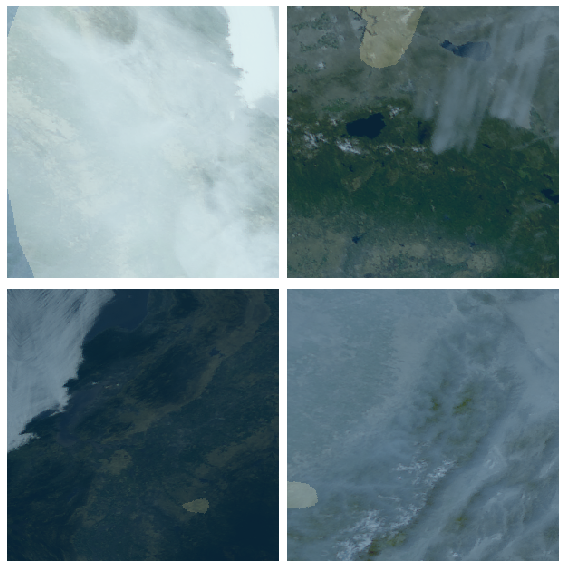

In [52]:
data.show_batch()

In [226]:
## normalization code adapted from: https://forums.fast.ai/t/normalizing-your-dataset/49799
def online_mean_and_sd(loader):
    """Compute the mean and sd in an online fashion

        Var[x] = E[X^2] - E^2[X]
    """
    cnt = 0
    fst_moment = torch.empty(5)
    snd_moment = torch.empty(5)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)

        cnt += nb_pixels
    
    return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

In [29]:
data_mean, data_std = online_mean_and_sd(data.dl())

In [37]:
print(f"data mean: {data_mean}\ndata std: {data_std}")

data mean: tensor([0.3789, 0.3693, 0.2956, 0.3618, 0.3618])
data std: tensor([0.1810, 0.1761, 0.2012, 0.1787, 0.1787])


## Extra code

* Testing conversion of geojson to MSCOCO annotations for labeling...

In [8]:
import rasterio
import shapely

In [9]:
## test files
'true_color_G16_doy206_s201807252002_e201807252004.tiff'
'true_color_G16_doy303_s201810302347_e201810302349.tiff'

'true_color_G16_doy303_s201810302347_e201810302349.tiff'

In [41]:
## direct copy from generating mask code.... can probably add generate json in the same function
file_name = 'true_color_G16_doy303_s201810302347_e201810302349.tiff'
src_file_name = '../data/img/{}'.format(file_name)

# get filter parameters from filename string
param_dict = h.get_true_color_filename_split_dict(src_file_name)

# filter the smoke plume data to what we need
filtered_smoke_df = h.filter_plumes(cali_fire_season_plumes, param_dict)

## retrieve transform from GeoTiff for converting to pixel coordinates
img = rasterio.open(src_file_name)
inverse_transform = ~img.meta['transform']

In [23]:
~img.meta['transform']

Affine(115.93315757866647, 0.0, 14431.591669507032,
       0.0, -126.57331954668618, 5317.282247216471)

In [42]:
inverse_transform

Affine(115.93315757866647, 0.0, 14431.591669507032,
       0.0, -126.57331954668618, 5317.282247216471)

In [256]:
annotation_list_1 = geom2annotation(criteria, file_name, 2, inverse_transform)

In [244]:
annotation_list + annotation_list_1

[{'id': 1,
  'image_id': 1,
  'category_id': 1,
  'segmentation': [[1200.0000000000018,
    24.52420397255173,
    1192.2488250174483,
    25.303652030535886,
    1103.2469399443053,
    24.096522282018668,
    1066.7604565911479,
    18.06100011275521,
    1044.6485254461695,
    10.818474768293527,
    1019.1683434125061,
    -9.094947017729282e-13,
    1200.0000000000018,
    -9.094947017729282e-13,
    1200.0000000000018,
    24.52420397255173]],
  'area': 3617.675236603902,
  'bbox': [1019.1683434125061,
   -9.094947017729282e-13,
   180.83165658749567,
   25.303652030536796],
  'iscrowd': 0},
 {'id': 2,
  'image_id': 1,
  'category_id': 1,
  'segmentation': [[1098.683390897777,
    -9.094947017729282e-13,
    1095.4098584919866,
    2.9783967822522754,
    1062.1521135773964,
    6.454859576921081,
    1045.5238207858893,
    5.295954263152453,
    1037.9783784446408,
    -9.094947017729282e-13,
    1098.683390897777,
    -9.094947017729282e-13]],
  'area': 279.4175013485856,
  '

In [245]:
output = {"info": {
    "description": "Test Smoke Dataset",
    "version": "0.1",
    "year": 2020,
    "contributor": "Jeff Wen",
    "date_created": "2020/07/22"},
 "licenses": [
     {
        "url": "",
        "id": 0,
        "name": ""
    }],
 "images": [
      {
         "width":1200,
         "date_captured":0,
         "coco_url":"",
         "file_name":"true_color_G16_doy206_s201807252002_e201807252004.tiff",
         "id":1,
         "license":0,
         "flickr_url":"",
         "height":1200
      },
      {
         "width":1200,
         "date_captured":0,
         "coco_url":"",
         "file_name":"true_color_G16_doy303_s201810302347_e201810302349.tiff",
         "id":2,
         "license":0,
         "flickr_url":"",
         "height":1200
      }
   ],
 "annotations": annotation_list + annotation_list_1,
 "categories": [{'supercategory':"", 'id': 0, 'name': 'background'},
                 {'supercategory':"", 'id': 1, 'name': 'smoke'}]
         }

In [246]:
with open("../data/test_labels.json", 'w') as outfile:
    json.dump(output, outfile)

In [187]:
criteria['geometry']

118     POLYGON ((-114.13121 41.81575, -114.19807 41.8...
120     POLYGON ((-115.00513 42.00950, -115.03337 41.9...
123     POLYGON ((-114.29757 42.00950, -114.47463 41.9...
259     MULTIPOLYGON (((-121.53015 42.00950, -121.5301...
320     POLYGON ((-119.90278 42.00950, -119.93394 41.8...
554     POLYGON ((-114.13121 41.27954, -114.19270 41.2...
656     POLYGON ((-122.81165 40.71585, -122.82953 40.8...
1671    POLYGON ((-120.11156 37.84887, -120.01619 37.9...
1724    POLYGON ((-119.96851 37.83099, -119.87910 37.8...
Name: geometry, dtype: geometry

In [353]:
MultiPolygon

shapely.geometry.multipolygon.MultiPolygon

In [252]:
img.transform

Affine(0.008625659999999999, 0.0, -124.48200299999999,
       0.0, -0.007900559166666661, 42.009502999999995)

In [213]:
h.polygon_to_coco(shapely.affinity.affine_transform(criteria['geometry'].iloc[0], [inverse_transform.a,
                                                      inverse_transform.b,
                                                      inverse_transform.d,
                                                      inverse_transform.e,
                                                      inverse_transform.xoff,
                                                      inverse_transform.yoff]))

[1200.0000000000018,
 24.52420397255173,
 1192.2488250174483,
 25.303652030535886,
 1103.2469399443053,
 24.096522282018668,
 1066.7604565911479,
 18.06100011275521,
 1044.6485254461695,
 10.818474768293527,
 1019.1683434125061,
 -9.094947017729282e-13,
 1200.0000000000018,
 -9.094947017729282e-13,
 1200.0000000000018,
 24.52420397255173]

In [225]:
shapely.affinity.affine_transform(criteria['geometry'].iloc[0], [inverse_transform.a,
                                                      inverse_transform.b,
                                                      inverse_transform.d,
                                                      inverse_transform.e,
                                                      inverse_transform.xoff,
                                                      inverse_transform.yoff]).bounds

(757.9272774489145, 60.28585951352943, 782.6929185708686, 123.24811186887382)

In [257]:
criteria

,Density,End,Satellite,Start,year,month,day,start_doy,end_doy,start_time,end_time,view,doy,time,area,area_zscore,density_area_zscore,geometry
118,16.0,2018206 2002,GOES-EAST,2018206 1802,2018,07,25,206,206,1802,2002,C,206,2002,0.246536,-0.296739,-0.355173,"POLYGON ((-114.13121 41.81575, -114.19807 41.8..."
120,16.0,2018206 1845,GOES-EAST,2018206 1715,2018,07,25,206,206,1715,1845,F,206,1845,0.019042,-0.317067,-0.374241,"POLYGON ((-115.00513 42.00950, -115.03337 41.9..."
123,27.0,2018206 2002,GOES-EAST,2018206 1802,2018,07,25,206,206,1802,2002,C,206,2002,0.088650,-0.310847,-0.372625,"POLYGON ((-114.29757 42.00950, -114.47463 41.9..."
259,27.0,2018206 2002,GOES-EAST,2018206 2002,2018,07,25,206,206,2002,2002,C,206,2002,2.248736,-0.117830,-0.016480,"MULTIPOLYGON (((-121.53015 42.00950, -121.5301..."
320,16.0,2018206 2002,GOES-EAST,2018206 2002,2018,07,25,206,206,2002,2002,C,206,2002,6.241456,0.238943,0.147297,"POLYGON ((-119.90278 42.00950, -119.93394 41.8..."
554,5.0,2018206 2002,GOES-EAST,2018206 1802,2018,07,25,206,206,1802,2002,C,206,2002,0.932807,-0.235417,-0.220148,"POLYGON ((-114.13121 41.27954, -114.19270 41.2..."
656,27.0,2018206 2002,GOES-EAST,2018206 2002,2018,07,25,206,206,2002,2002,C,206,2002,1.208649,-0.210768,-0.187965,"POLYGON ((-122.81165 40.71585, -122.82953 40.8..."
1671,16.0,2018206 2002,GOES-EAST,2018206 2002,2018,07,25,206,206,2002,2002,C,206,2002,6.859925,0.294207,0.199135,"POLYGON ((-120.11156 37.84887, -120.01619 37.9..."
1724,27.0,2018206 2002,GOES-EAST,2018206 2002,2018,07,25,206,206,2002,2002,C,206,2002,3.428223,-0.012436,0.177989,"POLYGON ((-119.96851 37.83099, -119.87910 37.8..."


## COCO json to polygon dataframe

* read in modified json and convert to modified smoke plume data frame

In [92]:
# read in the modified plume data
original_plumes = gpd.read_file('../data/test_coco_smoke_df.geojson')

In [93]:
with open('../data/testing/test/annotations/updated_2.json') as f:
    updated_coco_json_dict = json.load(f)

In [94]:
img_path='../data/img/'

for image in updated_coco_json_dict['images']:
    print(image['file_name'], image['id'])
    
    src = rasterio.open(img_path + image['file_name'])
    
    transform = src.meta['transform']
    
    print(transform)

true_color_G16_doy123_s201805030000_e201805030011.tiff 1
| 0.01, 0.00,-124.48|
| 0.00,-0.01, 42.01|
| 0.00, 0.00, 1.00|
true_color_G16_doy123_s201805030115_e201805030126.tiff 2
| 0.01, 0.00,-124.48|
| 0.00,-0.01, 42.01|
| 0.00, 0.00, 1.00|
true_color_G16_doy124_s201805042330_e201805042341.tiff 3
| 0.01, 0.00,-124.48|
| 0.00,-0.01, 42.01|
| 0.00, 0.00, 1.00|
true_color_G16_doy128_s201805082002_e201805082004.tiff 4
| 0.01, 0.00,-124.48|
| 0.00,-0.01, 42.01|
| 0.00, 0.00, 1.00|
true_color_G16_doy128_s201805082202_e201805082204.tiff 5
| 0.01, 0.00,-124.48|
| 0.00,-0.01, 42.01|
| 0.00, 0.00, 1.00|


In [105]:
original_plumes

,Density,End,Satellite,Start,year,month,day,start_doy,end_doy,start_time,...,view,doy,time,area,area_zscore,density_area_zscore,image_id,explode_id,annotation_id,geometry
0,27.0,2018123 0000,GOES-EAST,2018123 0000,2018,05,03,123,123,0000,...,F,123,0000,0.003256,-0.318477,-0.386705,1,0,1,"POLYGON ((-120.79514 36.86359, -120.72941 36.8..."
1,5.0,2018123 0115,GOES-EAST,2018123 0115,2018,05,03,123,123,0115,...,F,123,0115,0.143946,-0.305906,-0.285386,2,0,2,"POLYGON ((-121.05788 42.00950, -121.09442 41.9..."
2,5.0,2018123 0115,GOES-EAST,2018123 0115,2018,05,03,123,123,0115,...,F,123,0115,0.241699,-0.297171,-0.277302,2,0,3,"POLYGON ((-121.44654 42.00950, -121.30861 41.9..."
3,5.0,2018123 0115,GOES-EAST,2018123 0115,2018,05,03,123,123,0115,...,F,123,0115,0.187252,-0.302036,-0.281805,2,0,4,"POLYGON ((-120.79748 36.87064, -120.57449 36.7..."
4,16.0,2018123 0115,GOES-EAST,2018123 0115,2018,05,03,123,123,0115,...,F,123,0115,0.078568,-0.311748,-0.369252,2,0,5,"POLYGON ((-120.79748 36.84481, -120.69186 36.7..."
5,27.0,2018123 0000,GOES-EAST,2018123 0000,2018,05,03,123,123,0000,...,F,123,0000,0.003256,-0.318477,-0.386705,2,0,6,"POLYGON ((-120.79514 36.86359, -120.72941 36.8..."
6,5.0,2018124 2330,GOES-EAST,2018124 2130,2018,05,04,124,124,2130,...,F,124,2330,0.041406,-0.315069,-0.293866,3,0,7,"POLYGON ((-117.51052 33.39316, -117.41794 33.3..."
7,5.0,2018128 2002,GOES-EAST,2018128 1802,2018,05,08,128,128,1802,...,C,128,2002,0.158428,-0.304612,-0.284188,4,0,8,"POLYGON ((-121.13846 39.99357, -121.12713 40.0..."
8,5.0,2018128 2202,GOES-EAST,2018128 2002,2018,05,08,128,128,2002,...,C,128,2202,0.429303,-0.280408,-0.261787,5,0,9,"POLYGON ((-121.10782 39.97157, -121.17157 40.0..."


In [104]:
updated_coco_json_dict['images']

[{'coco_url': '',
  'id': 1,
  'flickr_url': '',
  'file_name': 'true_color_G16_doy123_s201805030000_e201805030011.tiff',
  'date_captured': 0,
  'width': 1200,
  'license': 0,
  'height': 1200},
 {'coco_url': '',
  'id': 2,
  'flickr_url': '',
  'file_name': 'true_color_G16_doy123_s201805030115_e201805030126.tiff',
  'date_captured': 0,
  'width': 1200,
  'license': 0,
  'height': 1200},
 {'coco_url': '',
  'id': 3,
  'flickr_url': '',
  'file_name': 'true_color_G16_doy124_s201805042330_e201805042341.tiff',
  'date_captured': 0,
  'width': 1200,
  'license': 0,
  'height': 1200},
 {'coco_url': '',
  'id': 4,
  'flickr_url': '',
  'file_name': 'true_color_G16_doy128_s201805082002_e201805082004.tiff',
  'date_captured': 0,
  'width': 1200,
  'license': 0,
  'height': 1200},
 {'coco_url': '',
  'id': 5,
  'flickr_url': '',
  'file_name': 'true_color_G16_doy128_s201805082202_e201805082204.tiff',
  'date_captured': 0,
  'width': 1200,
  'license': 0,
  'height': 1200}]

In [96]:
## extract xy coordinates and create polygon geometry
xs = updated_coco_json_dict['annotations'][12]['segmentation'][0][0::2]
ys = updated_coco_json_dict['annotations'][12]['segmentation'][0][1::2]
coco_shape = shapely.geometry.Polygon([[point[0], point[1]] for point in zip(xs, ys)])

## transform from xy coordinates back to lat long 
transformed_coco_shape = shapely.affinity.affine_transform(coco_shape,
                                                                 [transform.a,
                                                                  transform.b,
                                                                  transform.d,
                                                                  transform.e,
                                                                  transform.xoff,
                                                                  transform.yoff])

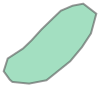

In [97]:
transformed_coco_shape

In [113]:
updated_coco_json_dict['annotations']

[{'area': 49,
  'id': 1,
  'segmentation': [[427.42966914995486,
    651.3347842151679,
    435.0499555976003,
    656.6827601126543,
    435.322398517912,
    660.5451449586208,
    430.15177968990247,
    660.5451449586208,
    425.524887370937,
    652.2261135314147,
    427.42966914995486,
    651.3347842151679]],
  'category_id': 1,
  'bbox': [425.524887370937,
   651.3347842151679,
   9.797511146975012,
   9.210360743452839],
  'image_id': 1,
  'iscrowd': 0,
  'attributes': {'occluded': False}},
 {'area': 3549,
  'id': 2,
  'segmentation': [[351.91111412817736,
    -9.094947017729282e-13,
    367.90147072803666,
    4.419687171930491,
    403.6181579148724,
    28.559750675874056,
    396.47435674487497,
    45.272112068860224,
    368.9216825147305,
    59.75615017122618,
    327.0814059445893,
    58.27068569302628,
    322.65855598296366,
    42.672422658690266,
    329.8023571529593,
    12.961614214857946,
    334.9365756349125,
    -9.094947017729282e-13,
    351.9111141281

In [174]:
def coco_to_polygon(coco_json_dict, img_path='../data/img/'):
    
    ## image information
    image_info = pd.DataFrame(coco_json_dict['images'])
    
    polygon_list = []
    
    for annotation in coco_json_dict['annotations']:
        
        ## associated image id
        img_id = annotation['image_id']
        
        ## open image and get transform data
        img_file_name = image_info.loc[image_info['id']==img_id]['file_name'].values[0]
        src = rasterio.open(img_path + img_file_name)
        transform = src.meta['transform']
        src.close()
    
        ## extract metadata from filename
        params_dict = h.get_true_color_filename_split_dict(img_file_name)
        
        ## extract xy coordinates and create polygon geometry
        xs = annotation['segmentation'][0][0::2]
        ys = annotation['segmentation'][0][1::2]
        coco_shape = shapely.geometry.Polygon([[point[0], point[1]] for point in zip(xs, ys)])

        ## transform from xy coordinates back to lat long 
        transformed_coco_shape = shapely.affinity.affine_transform(coco_shape,
                                                                         [transform.a,
                                                                          transform.b,
                                                                          transform.d,
                                                                          transform.e,
                                                                          transform.xoff,
                                                                          transform.yoff])
        
        ## add the geometry and append to running list of polygons
        params_dict['image_id'] = img_id
        params_dict['geometry'] = transformed_coco_shape
        polygon_list.append(params_dict)
        
    polygon_df = pd.DataFrame(polygon_list)
    
    return(polygon_df)

In [176]:
updated_polys = coco_to_polygon(updated_coco_json_dict)

In [188]:
updated_polys

,year,month,day,time,image_id,geometry
0,2018,05,03,0000,1,"POLYGON ((-120.79514 36.863594, -120.72941 36...."
1,2018,05,03,0115,2,"POLYGON ((-121.4465373793091 42.009503, -121.3..."
2,2018,05,03,0115,2,"POLYGON ((-120.79514 36.863594, -120.72941 36...."
3,2018,05,03,0115,2,"POLYGON ((-120.79748 36.870636, -120.57449 36...."
4,2018,05,03,0115,2,"POLYGON ((-121.0578833775403 42.009503, -121.0..."
5,2018,05,03,0115,2,"POLYGON ((-120.79748 36.844815, -120.69186 36...."
6,2018,05,04,2330,3,"POLYGON ((-117.505569192 33.40105373199999, -1..."
7,2018,05,08,2002,4,POLYGON ((-121.3690326305859 37.95689420160075...
8,2018,05,08,2002,4,"POLYGON ((-121.13846 39.99357100000001, -121.1..."
9,2018,05,08,2202,5,POLYGON ((-121.6494676625391 38.10896453477946...


In [186]:
original_plumes

,Density,End,Satellite,Start,year,month,day,start_doy,end_doy,start_time,...,view,doy,time,area,area_zscore,density_area_zscore,image_id,explode_id,annotation_id,geometry
0,27.0,2018123 0000,GOES-EAST,2018123 0000,2018,05,03,123,123,0000,...,F,123,0000,0.003256,-0.318477,-0.386705,1,0,1,"POLYGON ((-120.79514 36.86359, -120.72941 36.8..."
1,5.0,2018123 0115,GOES-EAST,2018123 0115,2018,05,03,123,123,0115,...,F,123,0115,0.143946,-0.305906,-0.285386,2,0,2,"POLYGON ((-121.05788 42.00950, -121.09442 41.9..."
2,5.0,2018123 0115,GOES-EAST,2018123 0115,2018,05,03,123,123,0115,...,F,123,0115,0.241699,-0.297171,-0.277302,2,0,3,"POLYGON ((-121.44654 42.00950, -121.30861 41.9..."
3,5.0,2018123 0115,GOES-EAST,2018123 0115,2018,05,03,123,123,0115,...,F,123,0115,0.187252,-0.302036,-0.281805,2,0,4,"POLYGON ((-120.79748 36.87064, -120.57449 36.7..."
4,16.0,2018123 0115,GOES-EAST,2018123 0115,2018,05,03,123,123,0115,...,F,123,0115,0.078568,-0.311748,-0.369252,2,0,5,"POLYGON ((-120.79748 36.84481, -120.69186 36.7..."
5,27.0,2018123 0000,GOES-EAST,2018123 0000,2018,05,03,123,123,0000,...,F,123,0000,0.003256,-0.318477,-0.386705,2,0,6,"POLYGON ((-120.79514 36.86359, -120.72941 36.8..."
6,5.0,2018124 2330,GOES-EAST,2018124 2130,2018,05,04,124,124,2130,...,F,124,2330,0.041406,-0.315069,-0.293866,3,0,7,"POLYGON ((-117.51052 33.39316, -117.41794 33.3..."
7,5.0,2018128 2002,GOES-EAST,2018128 1802,2018,05,08,128,128,1802,...,C,128,2002,0.158428,-0.304612,-0.284188,4,0,8,"POLYGON ((-121.13846 39.99357, -121.12713 40.0..."
8,5.0,2018128 2202,GOES-EAST,2018128 2002,2018,05,08,128,128,2002,...,C,128,2202,0.429303,-0.280408,-0.261787,5,0,9,"POLYGON ((-121.10782 39.97157, -121.17157 40.0..."
